# Cannabis Recommender

The purpose of this notebook is to build a content based cannabis recommender based on each strain's description text. 

The features of this dataset include: 
- Strain - trade name of the cannabis strain 
- Type - buckets strains into three types; hybrid, indica, and sativa
- Rating - an overall rating of the strain
- Effects - how the strain effects the mental state of the user
- Flavor - describes the flavor of the strain
- Description - a short description of each strain, the contents of the description vary strain to strain.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load in the data
cannabis = pd.read_csv(r'F:\Datasets\Cannabis StrainsFeatures.csv')

In [3]:
cannabis.head(10)

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."
5,3-Bears-Og,indica,4.4,"Relaxed,Happy,Sleepy,Creative,Euphoric\n","Sweet, Pungent, Earthy",3 Bears OG by Mephisto Genetics is an autoflow...
6,3-Kings,hybrid,4.4,"Relaxed,Euphoric,Happy,Uplifted,Hungry","Earthy,Sweet,Pungent","The 3 Kings marijuana strain, a holy trinity o..."
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",The indica-dominant 303 OG is a Colorado strai...
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",3D CBD from Snoop Dogg’s branded line of canna...
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet","Also known as Optimus Prime, the indica-domina..."


In [4]:
cannabis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Strain       2351 non-null   object 
 1   Type         2351 non-null   object 
 2   Rating       2351 non-null   float64
 3   Effects      2351 non-null   object 
 4   Flavor       2350 non-null   object 
 5   Description  2350 non-null   object 
dtypes: float64(1), object(5)
memory usage: 110.3+ KB


In [5]:
# any nulls?
cannabis.isnull().sum()

Strain         0
Type           0
Rating         0
Effects        0
Flavor         1
Description    1
dtype: int64

In [6]:
# drop nulls
cannabis = cannabis.dropna()

## Ratings

In [7]:
print('Distribution of Cannabis Types')
cannabis['Type'].value_counts()

Distribution of Cannabis Types


hybrid    1211
indica     698
sativa     440
Name: Type, dtype: int64

In [8]:
print('Rating by Type Average Score')
print(cannabis.groupby('Type').mean())
print('---------------')
print('Rating by Type Median Score')
print(cannabis.groupby('Type').median())

Rating by Type Average Score
          Rating
Type            
hybrid  4.381007
indica  4.389542
sativa  4.377727
---------------
Rating by Type Median Score
        Rating
Type          
hybrid     4.5
indica     4.5
sativa     4.4


Average ratings are nearly identical across all cannabis strain types. Indica is the highest rated on average by a small margin.

## Effects

In [9]:
cannabis['Effects'].unique()

array(['Creative,Energetic,Tingly,Euphoric,Relaxed',
       'Relaxed,Aroused,Creative,Happy,Energetic',
       'Uplifted,Happy,Relaxed,Energetic,Creative', ...,
       'Happy,Energetic,Uplifted,Euphoric,Focused',
       'Relaxed,Sleepy,Talkative,Euphoric,Happy',
       'Hungry,Relaxed,Uplifted,Happy,Sleepy'], dtype=object)

In [11]:
# simple text cleaning function 

def clean_text(df, col_to_clean, new_col_name, lemmatize=False):
    # define lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # remove characters, make lower case, tokenize
    df[new_col_name] = df[col_to_clean].apply(\
    lambda x : ' '.join([(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

    # same as above but with a lemmatizer step
    if lemmatize is True:
        df[new_col_name] = df[col_to_clean].apply(\
        lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
        for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x)))]))

    return df

In [12]:
# preview results
clean_text(cannabis, 'Effects', 'cleaned_effects')

,Strain,Type,Rating,Effects,Flavor,Description,lem_description,cleaned_effects
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,100 og is a 50 50 hybrid strain that pack a st...,creative energetic tingly euphoric relaxed
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,the 98 aloha white widow is an especially pote...,relaxed aroused creative happy energetic
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,1024 is a sativa dominant hybrid bred in spain...,uplifted happy relaxed energetic creative
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,13 dawgs is a hybrid of g13 and chemdawg genet...,tingly creative hungry relaxed uplifted
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",also known a kosher tangie 24k gold is a 60 in...,happy relaxed euphoric uplifted talkative
...,...,...,...,...,...,...,...,...
2346,Zeus-Og,hybrid,4.7,"Happy,Uplifted,Relaxed,Euphoric,Energetic","Earthy,Woody,Pine",Zeus OG is a hybrid cross between Pineapple OG...,zeus og is a hybrid cross between pineapple og...,happy uplifted relaxed euphoric energetic
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",Zkittlez is an indica-dominant mix of Grape Ap...,zkittlez is an indica dominant mix of grape ap...,relaxed happy euphoric uplifted sleepy
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",Zombie Kush by Ripper Seeds comes from two dif...,zombie kush by ripper seed come from two diffe...,relaxed sleepy talkative euphoric happy
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",If you’re looking to transform into a flesh-ea...,if you re looking to transform into a flesh ea...,relaxed sleepy euphoric happy hungry


In [13]:
# function to create most commonly found words and visualize

def create_word_freq(df, col, top_n):

    words = ' '.join(cannabis[col]).split()

    top_n = top_n

    word_dist = nltk.FreqDist(words)
    print('All frequencies:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_n),
                    columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)

    rslt = pd.DataFrame(word_dist.most_common(top_n),
                    columns=['Word', 'Frequency']).set_index('Word')

    plt.style.use('ggplot')

    rslt.plot.bar(rot=45)

All frequencies:
        Word  Frequency
0      happy       1900
1    relaxed       1760
2   euphoric       1670
3   uplifted       1535
4   creative        771
5     sleepy        757
6  energetic        665
7    focused        611
8     hungry        490
9  talkative        371


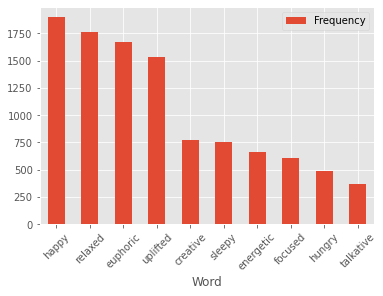

In [14]:
create_word_freq(cannabis, 'cleaned_effects', 10)

## Flavor

Cannabis has many unique flavors mostly due to the volatile terpenes within the plant. These terpenes combine to create unique flavors, similar to that of hops found in beer. Many descriptors of cannabis are shared with beer such as grapefruit, citrus, piney, etc. Let's take a look at some of the flavor descriptors found in the data.

In [148]:
# print out the unique flavor values
cannabis['Flavor'].unique()

array(['Earthy,Sweet,Citrus', 'Flowery,Violet,Diesel',
       'Spicy/Herbal,Sage,Woody', ..., 'Spicy/Herbal,Earthy,Sweet',
       'Mint,Sweet,Grapefruit', 'Diesel,Pungent,Sage'], dtype=object)

In [16]:
# apply the clean_text function to the flavor column
clean_text(cannabis, 'Flavor', 'cleaned_flavor')

,Strain,Type,Rating,Effects,Flavor,Description,lem_description,cleaned_effects,cleaned_flavor
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,100 og is a 50 50 hybrid strain that pack a st...,creative energetic tingly euphoric relaxed,earthy sweet citrus
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,the 98 aloha white widow is an especially pote...,relaxed aroused creative happy energetic,flowery violet diesel
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,1024 is a sativa dominant hybrid bred in spain...,uplifted happy relaxed energetic creative,spicy herbal sage woody
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,13 dawgs is a hybrid of g13 and chemdawg genet...,tingly creative hungry relaxed uplifted,apricot citrus grapefruit
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",also known a kosher tangie 24k gold is a 60 in...,happy relaxed euphoric uplifted talkative,citrus earthy orange
...,...,...,...,...,...,...,...,...,...
2346,Zeus-Og,hybrid,4.7,"Happy,Uplifted,Relaxed,Euphoric,Energetic","Earthy,Woody,Pine",Zeus OG is a hybrid cross between Pineapple OG...,zeus og is a hybrid cross between pineapple og...,happy uplifted relaxed euphoric energetic,earthy woody pine
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",Zkittlez is an indica-dominant mix of Grape Ap...,zkittlez is an indica dominant mix of grape ap...,relaxed happy euphoric uplifted sleepy,sweet berry grape
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",Zombie Kush by Ripper Seeds comes from two dif...,zombie kush by ripper seed come from two diffe...,relaxed sleepy talkative euphoric happy,earthy sweet spicy herbal
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",If you’re looking to transform into a flesh-ea...,if you re looking to transform into a flesh ea...,relaxed sleepy euphoric happy hungry,sweet earthy pungent


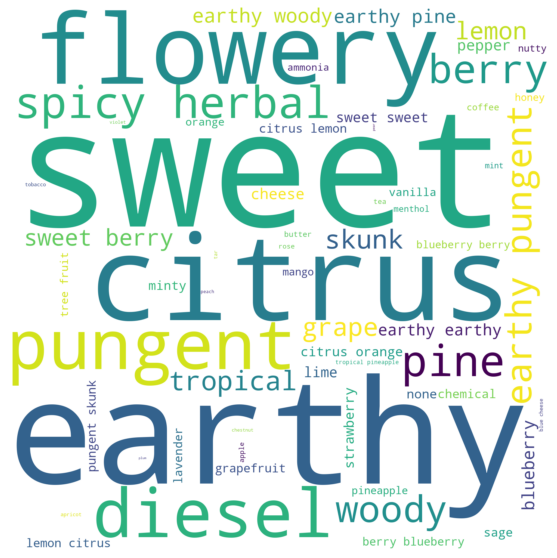

In [17]:
# create wordcloud visual
wordcloud = WordCloud(width = 2000, height = 2000, 
                background_color ='white', 
                max_words=100, 
                min_font_size = 10).generate(' '.join(cannabis['cleaned_flavor']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

As we can see, cannabis is highly diverse in its flavor profiles. A descriptor that popped out to me was coffee... I have never come across a cannabis strain that is coffee like, but nonetheless, doesn't mean it doesn't exist. 

All frequencies:
      Word  Frequency
0   earthy       1154
1    sweet       1093
2   citrus        553
3  pungent        458
4    berry        367
5     pine        314
6  flowery        272
7    woody        263
8   diesel        257
9    spicy        233


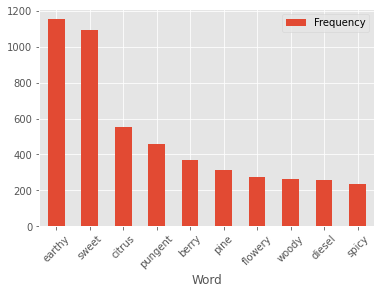

In [151]:
create_word_freq(cannabis, 'cleaned_flavor', 10)

### Description

<AxesSubplot:title={'center':'Word Count Distribution for Cannabis strain descriptions'}, ylabel='Frequency'>

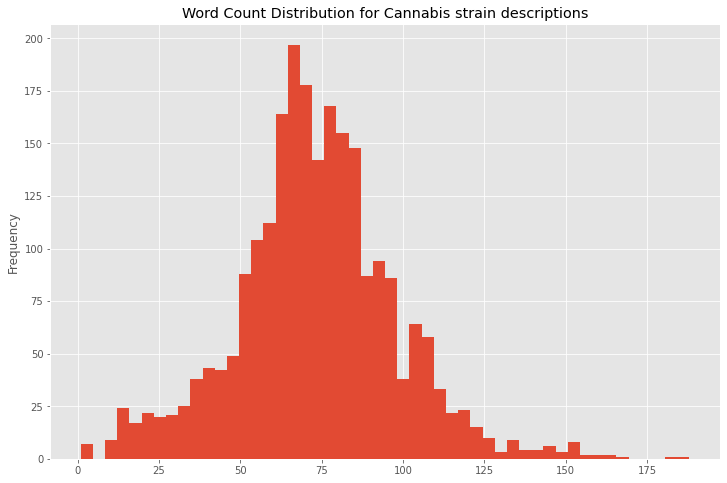

In [18]:
# Calculating the word count for the cannabis strain description
cannabis['word_count'] = cannabis['Description'].apply(lambda x: len(str(x).split()))

# Plotting the word count
cannabis['word_count'].plot(
    kind='hist',
    bins = 50,
    figsize = (12,8),title='Word Count Distribution for Cannabis strain descriptions')

The cannabis descriptions mostly fall in the 50-90 word range.

<AxesSubplot:title={'center':'Bigram disribution for the top 20 words in the cannabis strain description'}, xlabel='bigram'>

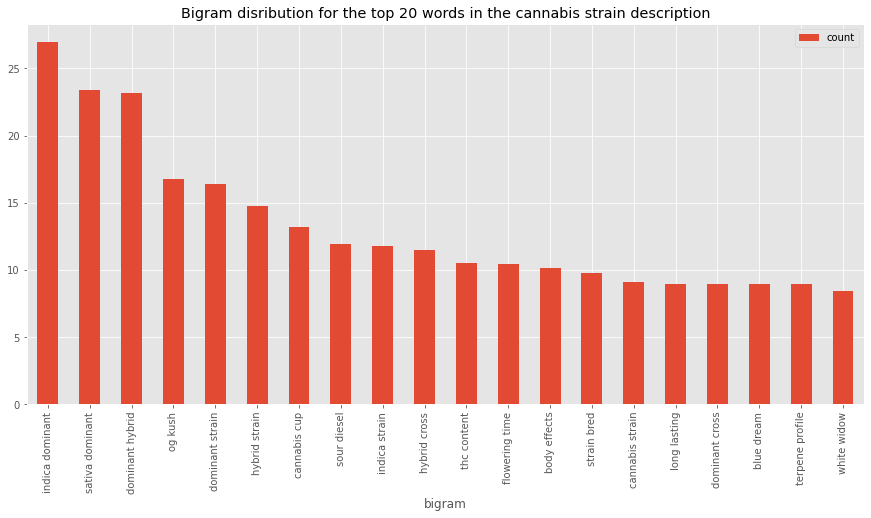

In [19]:
#Converting text descriptions into vectors using TF-IDF using Bigram
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
tfidf_matrix = tf.fit_transform(cannabis['Description'])
total_words = tfidf_matrix.sum(axis=0) 

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'bigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
bigram = bigram.head(20)#Plotting the bigram distribution
bigram.plot(x ='bigram', y='count', kind = 'bar', title = "Bigram disribution for the top 20 words in the cannabis strain description", figsize = (15,7), )

<AxesSubplot:title={'center':'Trigram disribution for the top 20 words in the cannabis strain description'}, xlabel='trigram'>

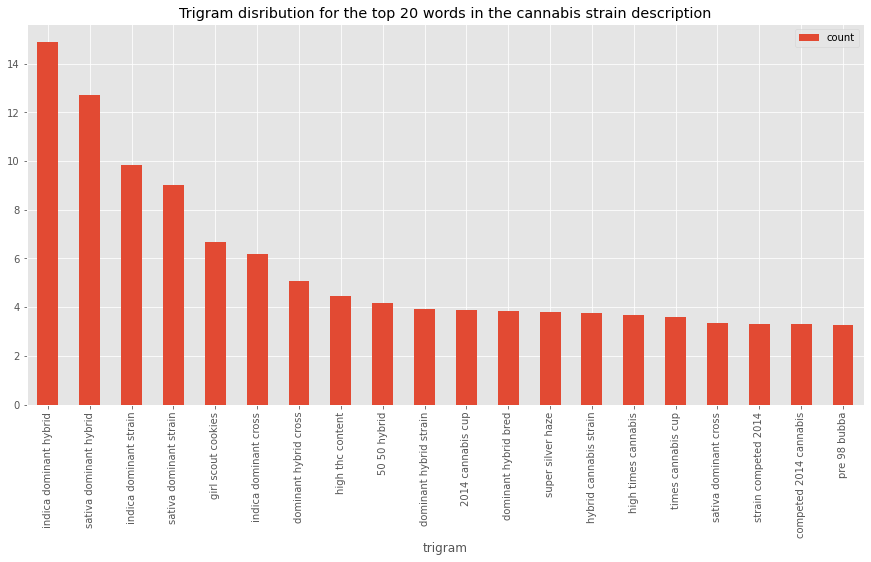

In [20]:
#Converting text descriptions into vectors using TF-IDF using Trigram
tf = TfidfVectorizer(ngram_range=(3, 3), stop_words='english')
tfidf_matrix = tf.fit_transform(cannabis['Description'])
total_words = tfidf_matrix.sum(axis=0)

#Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

#converting into dataframe 
trigram = pd.DataFrame(freq)
trigram.rename(columns = {0:'trigram', 1: 'count'}, inplace = True) 

#Taking first 20 records
trigram = trigram.head(20)#Plotting the trigramn distribution
trigram.plot(x ='trigram', y='count', kind = 'bar', title = "Trigram disribution for the top 20 words in the cannabis strain description", figsize = (15,7), )

In [21]:
#apply the lemmatizer to the description

clean_text(cannabis, 'Description', 'lem_description', lemmatize=True)

,Strain,Type,Rating,Effects,Flavor,Description,lem_description,cleaned_effects,cleaned_flavor,word_count
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...,100 og is a 50 50 hybrid strain that pack a st...,creative energetic tingly euphoric relaxed,earthy sweet citrus,69
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...,the 98 aloha white widow is an especially pote...,relaxed aroused creative happy energetic,flowery violet diesel,97
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...,1024 is a sativa dominant hybrid bred in spain...,uplifted happy relaxed energetic creative,spicy herbal sage woody,72
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...,13 dawgs is a hybrid of g13 and chemdawg genet...,tingly creative hungry relaxed uplifted,apricot citrus grapefruit,70
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%...",also known a kosher tangie 24k gold is a 60 in...,happy relaxed euphoric uplifted talkative,citrus earthy orange,93
...,...,...,...,...,...,...,...,...,...,...
2346,Zeus-Og,hybrid,4.7,"Happy,Uplifted,Relaxed,Euphoric,Energetic","Earthy,Woody,Pine",Zeus OG is a hybrid cross between Pineapple OG...,zeus og is a hybrid cross between pineapple og...,happy uplifted relaxed euphoric energetic,earthy woody pine,36
2347,Zkittlez,indica,4.6,"Relaxed,Happy,Euphoric,Uplifted,Sleepy","Sweet,Berry,Grape",Zkittlez is an indica-dominant mix of Grape Ap...,zkittlez is an indica dominant mix of grape ap...,relaxed happy euphoric uplifted sleepy,sweet berry grape,103
2348,Zombie-Kush,indica,5.0,"Relaxed,Sleepy,Talkative,Euphoric,Happy","Earthy,Sweet,Spicy/Herbal",Zombie Kush by Ripper Seeds comes from two dif...,zombie kush by ripper seed come from two diffe...,relaxed sleepy talkative euphoric happy,earthy sweet spicy herbal,78
2349,Zombie-Og,indica,4.4,"Relaxed,Sleepy,Euphoric,Happy,Hungry","Sweet,Earthy,Pungent",If you’re looking to transform into a flesh-ea...,if you re looking to transform into a flesh ea...,relaxed sleepy euphoric happy hungry,sweet earthy pungent,104


In [156]:
cannabis['Description'][2]

'1024 is a sativa dominant hybrid bred in spain by medical seed co the breeder claim to guard the secret genetics due to security reason but regardless of it genetic heritage 1024 is a thc powerhouse with a sweet and spicy bouquet subtle fruit flavor mix with an herbal musk to produce uplifting sativa effect one specific phenotype is noted for having a pungent odor that fill a room similar to burning incense'

In [157]:
cannabis['Description'][5]

'3 bear og by mephisto genetics is an autoflowering cross of bear og karma s og cut and triangle kush this indica dominant strain generates pungent flavorful bud in a smaller more manageable plant size mephisto genetics describes 3 bear og a a cornerstone to their artisanal collection blending the best attribute of the fabled og kush with a compact controllable growth structure the 3 bear og ha an approximate 70 day growth cycle and offer effect that stimulate the appetite while leading the body toward sleep'

In [158]:
cannabis['Description'][15]

'named after the telephone area code of the san fernando valley in los angeles 818 og is an og kush strain popular with patient for treating pain loss of appetite and insomnia not to be confused with the other og cut named for the locale the 818 og ha a very fruity flavor that is quite different from the sour earthy fuel taste found in the sfv og'

### Recommender Model Experimentation

In [22]:
# using lemmatized_text, create the corpus
corpus = cannabis['lem_description']

# FEATURE EXTRACTION
tfidf_model = TfidfVectorizer(max_features=500,
                              ngram_range=(1,3),
                              max_df=0.25,
                              min_df=0.05,
                              stop_words='english')

# define the matrix
tfidf_matrix = tfidf_model.fit_transform(corpus).todense()

tfidf_df = pd.DataFrame(tfidf_matrix)
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
pd.set_option('max_columns', None)
tfidf_df.head()

,afghani,anxiety,appetite,balanced,berry,best,blend,blue,blueberry,body effect,bred,breeder,buzz,cannabis,cannabis cup,cbd,cerebral,choice,citrus,combine,come,consumer,content,create,created,creative,creativity,crossing,crystal,cup,day,deep,delivers,dense,depression,diesel,dominant hybrid,dominant strain,earthy,energy,enjoy,euphoria,euphoric,floral,flower,flowering,flowering time,fruit,fruity,fuel,genetic,good,grape,great,green,grow,grower,ha,happy,haze,head,heavy,help,high,hint,hybrid cross,hybrid strain,indica dominant,indica dominant hybrid,indica dominant strain,indica strain,indoors,insomnia,known,kush,large,lasting,lemon,level,light,like,long,make,making,mental,mind,mix,mood,named,nausea,note,offer,og,og kush,orange,pain,parent,patient,perfect,phenotype,physical,pine,plant,potency,potent,powerful,produce,profile,provides,pungent,purple,quality,relaxation,relaxing,relief,resin,rich,sativa dominant,sativa dominant hybrid,skunk,skunky,smell,sour,spicy,stimulating,strain ha,stress,strong,taste,terpene,terpene profile,thc,thc content,time,trichomes,tropical,undertone,uplifting,use,variety,wa,week,white,yield
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.298308,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.229584,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.236681,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.192106,0.0,0.0,0.273326,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.30795,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.397146,0.0,0.000000,0.189272,0.0,0.0,0.0,0.000000,0.0,0.0,0.221171,0.0,0.000000,0.0,0.250683,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.263319,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.470317,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.167081,0.000000,0.0,0.146252,0.0,0.0,0.165282,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.255174,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.154499,0.0,0.0,0.0,0.0,0.314909,0.000000,0.0,0.0,0.0,0.15645,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.179944,0.0,0.0,0.000000,0.0,0.144118,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.157964,0.0,0.000000,0.0,0.203652,0.000000,0.000000,0.168735,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.174037,0.0,0.0,0.000000,0.0,0.0,0.19969,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.701809,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.206872,0.304044,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.218940,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.29103,0.0,0.0,0.31624,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.306922,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.276573,0.0,0.0,0.000000,0.0,0.000000,0.0,0.257431,0.0,0.0,0.252542,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.219722,0.282389,0.000000,0.0,0.0,0.0,0.311136,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.222114,0.0,0.0,0.00000,0.0,0.0,0.2392,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.277038,0.0,0.0,0.0,0.310718,0.0,0.0,0.000000,0.207819,0.000000,0.24443,0.0,0.0,0.0,0.000000,0.0,0.234000,0.000000,0.0,0.0,0.0,0.315082,0.0,0.303195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290927,0.000000,0.000000,0.0,0.225818,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.

In [23]:
# calculate the cosine similarity of the matrix
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Construct a reverse mapping of indices and strain names, and drop duplicate names, if any
indices = pd.Series(cannabis.index, index=cannabis['Strain']).drop_duplicates()

In [24]:
# Function that takes in cannabis strain name as input and gives recommendations 
def recommender(strain, cosine_sim=cosine_sim, df=cannabis, indices=indices):
    # Obtain the index of the cannabis strain that matches the name
    idx = indices[strain]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    canna_indices = [i[0] for i in sim_scores]

    
    return cannabis[['Strain', 'Type', 'Effects', 'Flavor', 'Description']].iloc[canna_indices]

In [25]:
# print out results - Zamaldelica will be the guinea pig 
recommender('13-Dawgs')

,Strain,Type,Effects,Flavor,Description
1049,Holy-Ghost,hybrid,"Relaxed,Euphoric,Hungry,Giggly,Happy","Earthy,Citrus,Grapefruit",Holy Ghost is a harmony of attractive genetics...
543,Chuckys-Bride,hybrid,"Giggly,Happy,Energetic,Euphoric,Talkative","Pungent,Lemon,Flowery",Chucky’s Bride is a cross of Exodus Cheese and...
1866,Silver-Kush,sativa,"Happy,Relaxed,Giggly,Uplifted,Focused","Earthy,Chemical,Citrus",Silver Kush is a sativa-dominant mix of Silver...
1382,Medusa,hybrid,"Relaxed,Happy,Euphoric,Creative,Uplifted","Earthy,Blueberry,Pungent","Medusa mixes smooth, sweet flavors with an ear..."
822,Fruity-Chronic-Juice,indica,"Relaxed,Euphoric,Happy,Uplifted,Creative","Citrus,Grapefruit,Tropical","Fruity Chronic Juice, bred by Delicious Seeds,..."


In [26]:
print('13-Dawgs Description: ')
print(cannabis['Description'][3])
print('')
print('RECOMMENDATIONS')
print('---------------------')
print('Holy Ghost: ')
print(cannabis['Description'][1049])
print('---------------------')
print('Chuckys Bride: ')
print(cannabis['Description'][543])
print('---------------------')
print('Silver-Kush: ')
print(cannabis['Description'][1866])
print('---------------------')
print('Medusa: ')
print(cannabis['Description'][1382])
print('---------------------')
print('Fruity Chronic Juice: ')
print(cannabis['Description'][822])

13-Dawgs Description: 
13 Dawgs is a hybrid of G13 and Chemdawg genetics bred by Canadian LP Delta 9 BioTech. The two potent strains mix to create a balance between indica and sativa effects. 13 Dawgs has a sweet earthy musk that brings a blend of woody citrus flavors. The effects of 13 Dawgs induce a happy, relaxed body buzz with a creative and focused mind that counters depression and stimulates the appetite.

RECOMMENDATIONS
---------------------
Holy Ghost: 
Holy Ghost is a harmony of attractive genetics that balance the relaxing nature of indicas with sativas’ cerebral activity. Parent strains Satori, Amnesia Haze, Pitbull, and Durban Poison combine to create a pungent blend of diesel and citrus aromas that are enhanced by an earthy exhale of spiced sandalwood. The interplay of sativa and indica genetics relax the body without putting you to sleep, and energize the mind without overstimulation. Holy Ghost is an enjoyable answer when faced with stress or depression. 
--------------

In [27]:
recommender('Bc-Roadkill')

,Strain,Type,Effects,Flavor,Description
1082,Ingrid,indica,"Relaxed,Euphoric,Creative,Sleepy,Happy","Cheese,Pungent,Skunk","Ingrid is a lesser-known indica, but it’s grow..."
237,Black-Mamba,indica,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Sweet,Grape,Woody",Black Mamba is named after the deadly African ...
749,El-Nino,hybrid,"Happy,Sleepy,Relaxed,Uplifted,Talkative","Earthy,Woody,Spicy/Herbal",Greenhouse Seed Company released El Niño in 19...
898,Golden-Tiger,sativa,"Talkative,Uplifted,Energetic,Euphoric,Happy","Minty,Lemon,Apricot",Golden Tiger is a resinous flower created from...
1187,King-Kong,hybrid,"Happy,Focused,Giggly,Relaxed,Uplifted","Earthy,Flowery,Pungent","King Kong, mothered by Ed Rosenthal Super Bud,..."


In [28]:
print('BC Roadkill Description: ')
print(cannabis['Description'][155])
print('')
print('RECOMMENDATIONS')
print('---------------------')
print('Ingrid: ')
print(cannabis['Description'][1082])
print('---------------------')
print('Black-Mamba: ')
print(cannabis['Description'][237])
print('---------------------')
print('El Nino: ')
print(cannabis['Description'][749])
print('---------------------')
print('Golden-Tiger: ')
print(cannabis['Description'][898])
print('---------------------')
print('King-Kong: ')
print(cannabis['Description'][1187])

BC Roadkill Description: 
BC Roadkill is another strain that British Columbia is proud to call their own. This top-shelf strain is rumored to be one of the stinkiest out there (though not in the same way that roadkill is). Growers love this strain for its consistent above average yields and 8 week flowering time. The flowers will be large and purple-blue with red hairs, and they typically reek of skunk and citrus. Its musky aroma is due to its BC Roadkill Skunk parent, which was bred with Deep Chunk to create this hybrid. Consumers also flock to scoop up this Roadkill for its strong buzz that is relaxing and trancey without being a complete knockout. Sleep may come easily, but so may euphoria and happy conversation, making this a daytime choice for many treating anxiety and stress.

RECOMMENDATIONS
---------------------
Ingrid: 
Ingrid is a lesser-known indica, but it’s growing in popularity as consumers begin to discover this gem of a strain. This plant can be grown indoors or out, bu

---

## Recommend Based on Effects as Input

- It makes more sense from a consumer perspective to enter their desired effects and recommend strains. Not sure how familiar the general public is with cannabis strain names.
- Three total words can be used for input.
- The recommender will run off a counting function, and recommend the highest rated strains with the desired effects that are input by the user.


In [29]:
def effects_reco(effect1, effect2, effect3):
    
    # count the user input words
    cannabis['word1'] = cannabis['cleaned_effects'].str.contains(effect1).astype(int)
    cannabis['word2'] = cannabis['cleaned_effects'].str.contains(effect2).astype(int)
    cannabis['word3'] = cannabis['cleaned_effects'].str.contains(effect3).astype(int)

    # add column to sum up the word match score
    cannabis['score'] = cannabis['word1'] + cannabis['word2'] + cannabis['word3']

    # return top recos, sort by Rating and word match score
    cannabis.sort_values(by=['Rating', 'score'], inplace=True, ascending=False)

    return cannabis[['Strain', 'Type', 'Effects', 'Description']][0:10]

In [31]:
effects_reco('sleepy', 'creative', 'hungry')

,Strain,Type,Effects,Description
678,Dolla-Sign-Og-Kush,indica,"Creative,Sleepy,Uplifted,Energetic,Hungry",Dolla Sign OG Kush by Ty Dolla Sign is an OG b...
878,Godzilla-Blood,hybrid,"Happy,Hungry,Relaxed,Sleepy,Creative",Godzilla Blood by Pua Mana 1st Hawaiian Pakalo...
1739,Queso,hybrid,"Sleepy,Tingly,Hungry,Creative,Euphoric",Created in 2011 by Kannabia Seeds using Cheese...
16,831-Og,indica,"Hungry,Relaxed,Creative,Euphoric,Aroused","831 OG, aka Santa Cruz OG, is an indica-domina..."
47,Afghanimal,indica,"Hungry,Relaxed,Aroused,Sleepy,Focused",Afghanimal by In House Genetics is a heavy ind...
113,Anonymous-Og,indica,"Relaxed,Sleepy,Happy,Euphoric,Hungry",The 3C Anonymous OG greets the nose with disti...
114,Anubis,indica,"Relaxed,Sleepy,Creative,Focused,Aroused",Anubis by Pyramid Seeds is the indica-dominant...
150,B-Witched,hybrid,"Euphoric,Relaxed,Happy,Hungry,Sleepy",B-Witched by Ocean Grown Seeds is a magical cr...
151,B-Witched,hybrid,"Euphoric,Relaxed,Happy,Hungry,Sleepy",B-Witched by Ocean Grown Seeds is a magical cr...
157,Bcn-Diesel,hybrid,"Sleepy,Focused,Happy,Hungry",BCN Diesel by Kannabia Seed Company is a punge...


In [32]:
effects_reco('euphoric', 'focused', 'energetic')

,Strain,Type,Effects,Description
1980,Spoetnik-1,indica,"Focused,Sleepy,Creative,Energetic,Euphoric",Spoetnik #1 by Paradise Seeds (not to be confu...
194,Bertberry-Cheesecake,sativa,"Uplifted,Creative,Euphoric,Focused,Energetic",Bertberry Cheesecake by Bert Baccarat is a bri...
789,Fighting-Buddha,sativa,"Creative,Energetic,Euphoric,Focused",Fighting Buddha by Chimera Seeds is a energeti...
840,Gi-001,hybrid,"Creative,Focused,Energetic,Uplifted,Euphoric",GI001 is a sativa-dominant cannabis strain dev...
1385,Mekamika-Haze,sativa,"Uplifted,Creative,Energetic,Euphoric,Focused",Mekamika Haze won Best Sativa at the 2015 Amst...
1603,Pineapple-Sage,sativa,"Uplifted,Creative,Energetic,Euphoric,Focused",Pineapple Sage by Love Genetics is a backcross...
1756,Rebel-God-Smoke,sativa,"Uplifted,Euphoric,Energetic,Focused,Happy",Rebel God Smoke is a pro-grade sativa-dominant...
1863,Silver-Calyx,hybrid,"Aroused,Energetic,Euphoric,Focused,Relaxed",Silver Calyx by Calyx Garden is a balanced hyb...
62,Alaska-Thunder-Grape,hybrid,"Tingly,Uplifted,Creative,Euphoric,Focused","From Sonoma County comes Alaska Thunder Grape,..."
97,Alpine-Blue,hybrid,"Uplifted,Creative,Energetic,Aroused,Euphoric",Alpine Blue is a 60/40 sativa-dominant hybrid ...


In [33]:
effects_reco('relaxed', 'sleepy', 'tingly')

,Strain,Type,Effects,Description
1414,Monolith,indica,"Relaxed,Sleepy,Tingly,Euphoric,Focused",Monolith is an indica-dominant strain with Afg...
810,Fred-Flipn-Stoned,indica,"Happy,Relaxed,Sleepy,Tingly,Euphoric",Fred Flipn’ Stoned is another wild herb plucke...
2227,Velvet-Purps,hybrid,"Happy,Relaxed,Euphoric,Sleepy,Tingly",Velvet Purps by Sun Roots Farm is an indica-do...
1409,Mochi,hybrid,"Sleepy,Happy,Hungry,Relaxed,Tingly",Mochi by Sherbinski is another strain that lea...
1554,Pacific-Blue,indica,"Tingly,Relaxed,Sleepy,Uplifted,Creative",Pacific Blue by Falcanna is a flavorful cut wi...
1723,Purple-Tears,hybrid,"Sleepy,Tingly,Happy,Hungry,Relaxed",Purple Tears by Dirt Farmer Genetics is a plea...
1771,Redd-Cross,hybrid,"Sleepy,Relaxed,Tingly,Hungry",Redd Cross is an indica-dominant hybrid bred b...
2213,Ultra-Banana,indica,"Sleepy,Tingly,Giggly,Hungry,Relaxed","Ultra Banana is a delicious, sleep-inducing cr..."
2252,Washing-Machine,indica,"Creative,Relaxed,Sleepy,Talkative,Tingly",Washing Machine by Ripper Seeds is a funky cut...
204,Big-Mac,indica,"Relaxed,Aroused,Sleepy,Talkative,Tingly",Big Mac by Federation Seeds is an indica-domin...


## Findings

As a baseline, the recommendations make sense. 

The first test strain, 13 Dawgs, is described as an uplifting strain that can help ward off depression and increase focus. The recommendations returned make sense, they're all described as uplifting and anti depression.

Using BC-Roadkill as the other test item, it is described as having a strong buzz effect while not "being a knockout". The recommended strains have mostly the same effects - balanced yet relaxing. Another good result that makes sense.

More data would be very useful to improve this recommender, specifically user information. With user interaction data, far more algorithmic options are available. 

Similar to Amazon's feature, Frequently Bought Together style recommender could also be built , but as above, individual user interactions would be needed.

Final recommender should return a polished dataframe, and be sure to show all of the Description column in the app output. 

# END 